<a href="https://colab.research.google.com/github/gitHubAndyLee2020/OpenAI_Gym_RL_Algorithms_Database/blob/main/SAC_Module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SAC

> About

- Consists of Actor, Critic, and Q networkers.
- For continuous action space.
- Actor: state -> mean and std for action distribution
- Critic: state -> expected reward
- Q Network: state + action -> expected reward

> Model Dependency

- Target Critic (discounted reward) -> Q Network; Q Network -> Actor; Q Network + Actor -> Critic; Critic (update) -> Critic

> Pro

- Stability

> Con

- Slow convergence

```
class NormalizedActions(gym.ActionWrapper):
  # Shifts the range of the action from -1 to 1 (output range of the model) to the action range's low to high and back
  def action(self, action):
    - Convert action value range from -1 to 1 to low to high
    # Note:
    # low + (action + 1.0) * 0.5 * (high - low)
    # = low + (0 ~ 1) * (high - low)
    # = low ~ high

  def reverse_action(self, action):
    - Conver action value range from low to high to -1 to 1
    # Note:
    # 2 * (action - low) / (high - low) - 1
    # = 2 * (0 ~ 1) - 1
    # = (0 ~ 2) - 1
    # = (-1 ~ 1)
```

```
# Transition is a tuple of state, action, reward, next state, done
```

```
class Actor(nn.Module):
  def __init__(self, state_dim, min_log_std, max_log_std):
    - Map state -> hidden layer 1 -> hidden layer 2 -> mean (mu head layer) and log standard deviation value (log standard deviation head)
    - Initialize minimum and maximum log standard deviation

  def forward(self, x):
    - Feed the input state through the network to get both mean value and log standard deviation value
    - The log standard deviation is the estimation of the uncertainty of the Actor's actions
    - The mean and log standard deviation values are generated through neural network instead of statistical function to allow the model to learn the mean and log standard deviation values for the action in each state
    - The log standard deviation value is clipped between the minimum and maximum log standard deviation values to stablize the learning
    - Return the mean value and log standard deviation value
```

```
class Critic(nn.Module):
  def __init__(self, state_dim):
    - Maps state -> hidden layer 1 -> hidden layer 2 -> expected reward

  def forward(self, x):
    - Feed the input state through the network to get the expected reward
    - Return the expected reward
```

```
class Q(nn.Module):
  def __init__(self, state_dim, action_dim):
    - Map state and action -> hidden layer 1 -> hidden layer 2 -> expected reward

  def forward(self, s, a):
    - Feed the input state and action through the network to get the expected reward
    - Return the expected reward
```

```
class SAC():
  def __init__(self):
    - Initialize Actor, Critic, Q, and Target Critic networks and Actor, Critic, and Q network optimizers
    - Initialize storage for collected transition data
    - Initialize Critic and Q network loss function to be Mean Square Estimate functions
    - Copy the weights from Critic network to Target Critic network

  def select_action(self, state):
    - Feed the input state to Actor network and get the mean value and log standard deviation value
    - Use the mean and standard deviation to get the action distribution following the normal distribution, and sample an action value from the distribution
    - Apply tanh layer to squeeze the action value between -1 and 1, and return the action value

  def store(self, s, a, r, s_, d):
    - Store transition in the storage, if the storage is full, replace the oldest item in the storage

  def get_action_log_prob(self, state):
    - Feed the state through the Actor network to get the mean and log standard deviation of the action distribution, and use these values to get the action distribution
    - Select an action value from the action normal distribution. Calculate the log probability of selecting the action, and return the log probability value
    - Return the squeezed action value (between -1 and 1), log probability value, original action value, action distribution mean, an action distribution standard deviation values
```

```
class SAC():
  # ... continued ...
  def update(self):
    - For some number of steps repeat the following update loop
    # Update loop
    - 1. Fetch an unwrap a random transition from the training data storage and get the state, action, reward, next state, and done
    - 2. Calculate the target expected reward value using reward + gamma * next state's expected reward value; where next state's expected value is calculated by feeding the next state to target critic network (next_q_value)
    - 3. Generate the expected reward value by feeding the state to Critic network, and generate the Q value by feeding the state and action to Q network (expected_value, expected_Q)
    - 4. Get the sample action and log probability from get_action_log_prob function from above by passing in state as input (sample_action, log_prob)
    - 5. Calculate new Q value by feeding state and sample action to Q network (expected_new_Q)
    - 6. Get the discounted new Q value by subtracting the log probability (negative value) from the new Q value. Lower probability leads to large negative log probability, leading to large loss that will make more adjustments to the model, prompting the model to more likely select these actions (next_value)
    - 7. Refer to the following chart for how the loss is calculated for each network
    - 8. Apply backpropagation to each network
    - 9. Copy the weights from Critic network to target Critic network
```

```
def main():
  - Run the following training loop for some number of epochs
  - 1. Collect transitions until some step limit or the game ends
  - 2. When enough data is collected, start updating the agent
```

### Variable Dependency Graph for update function

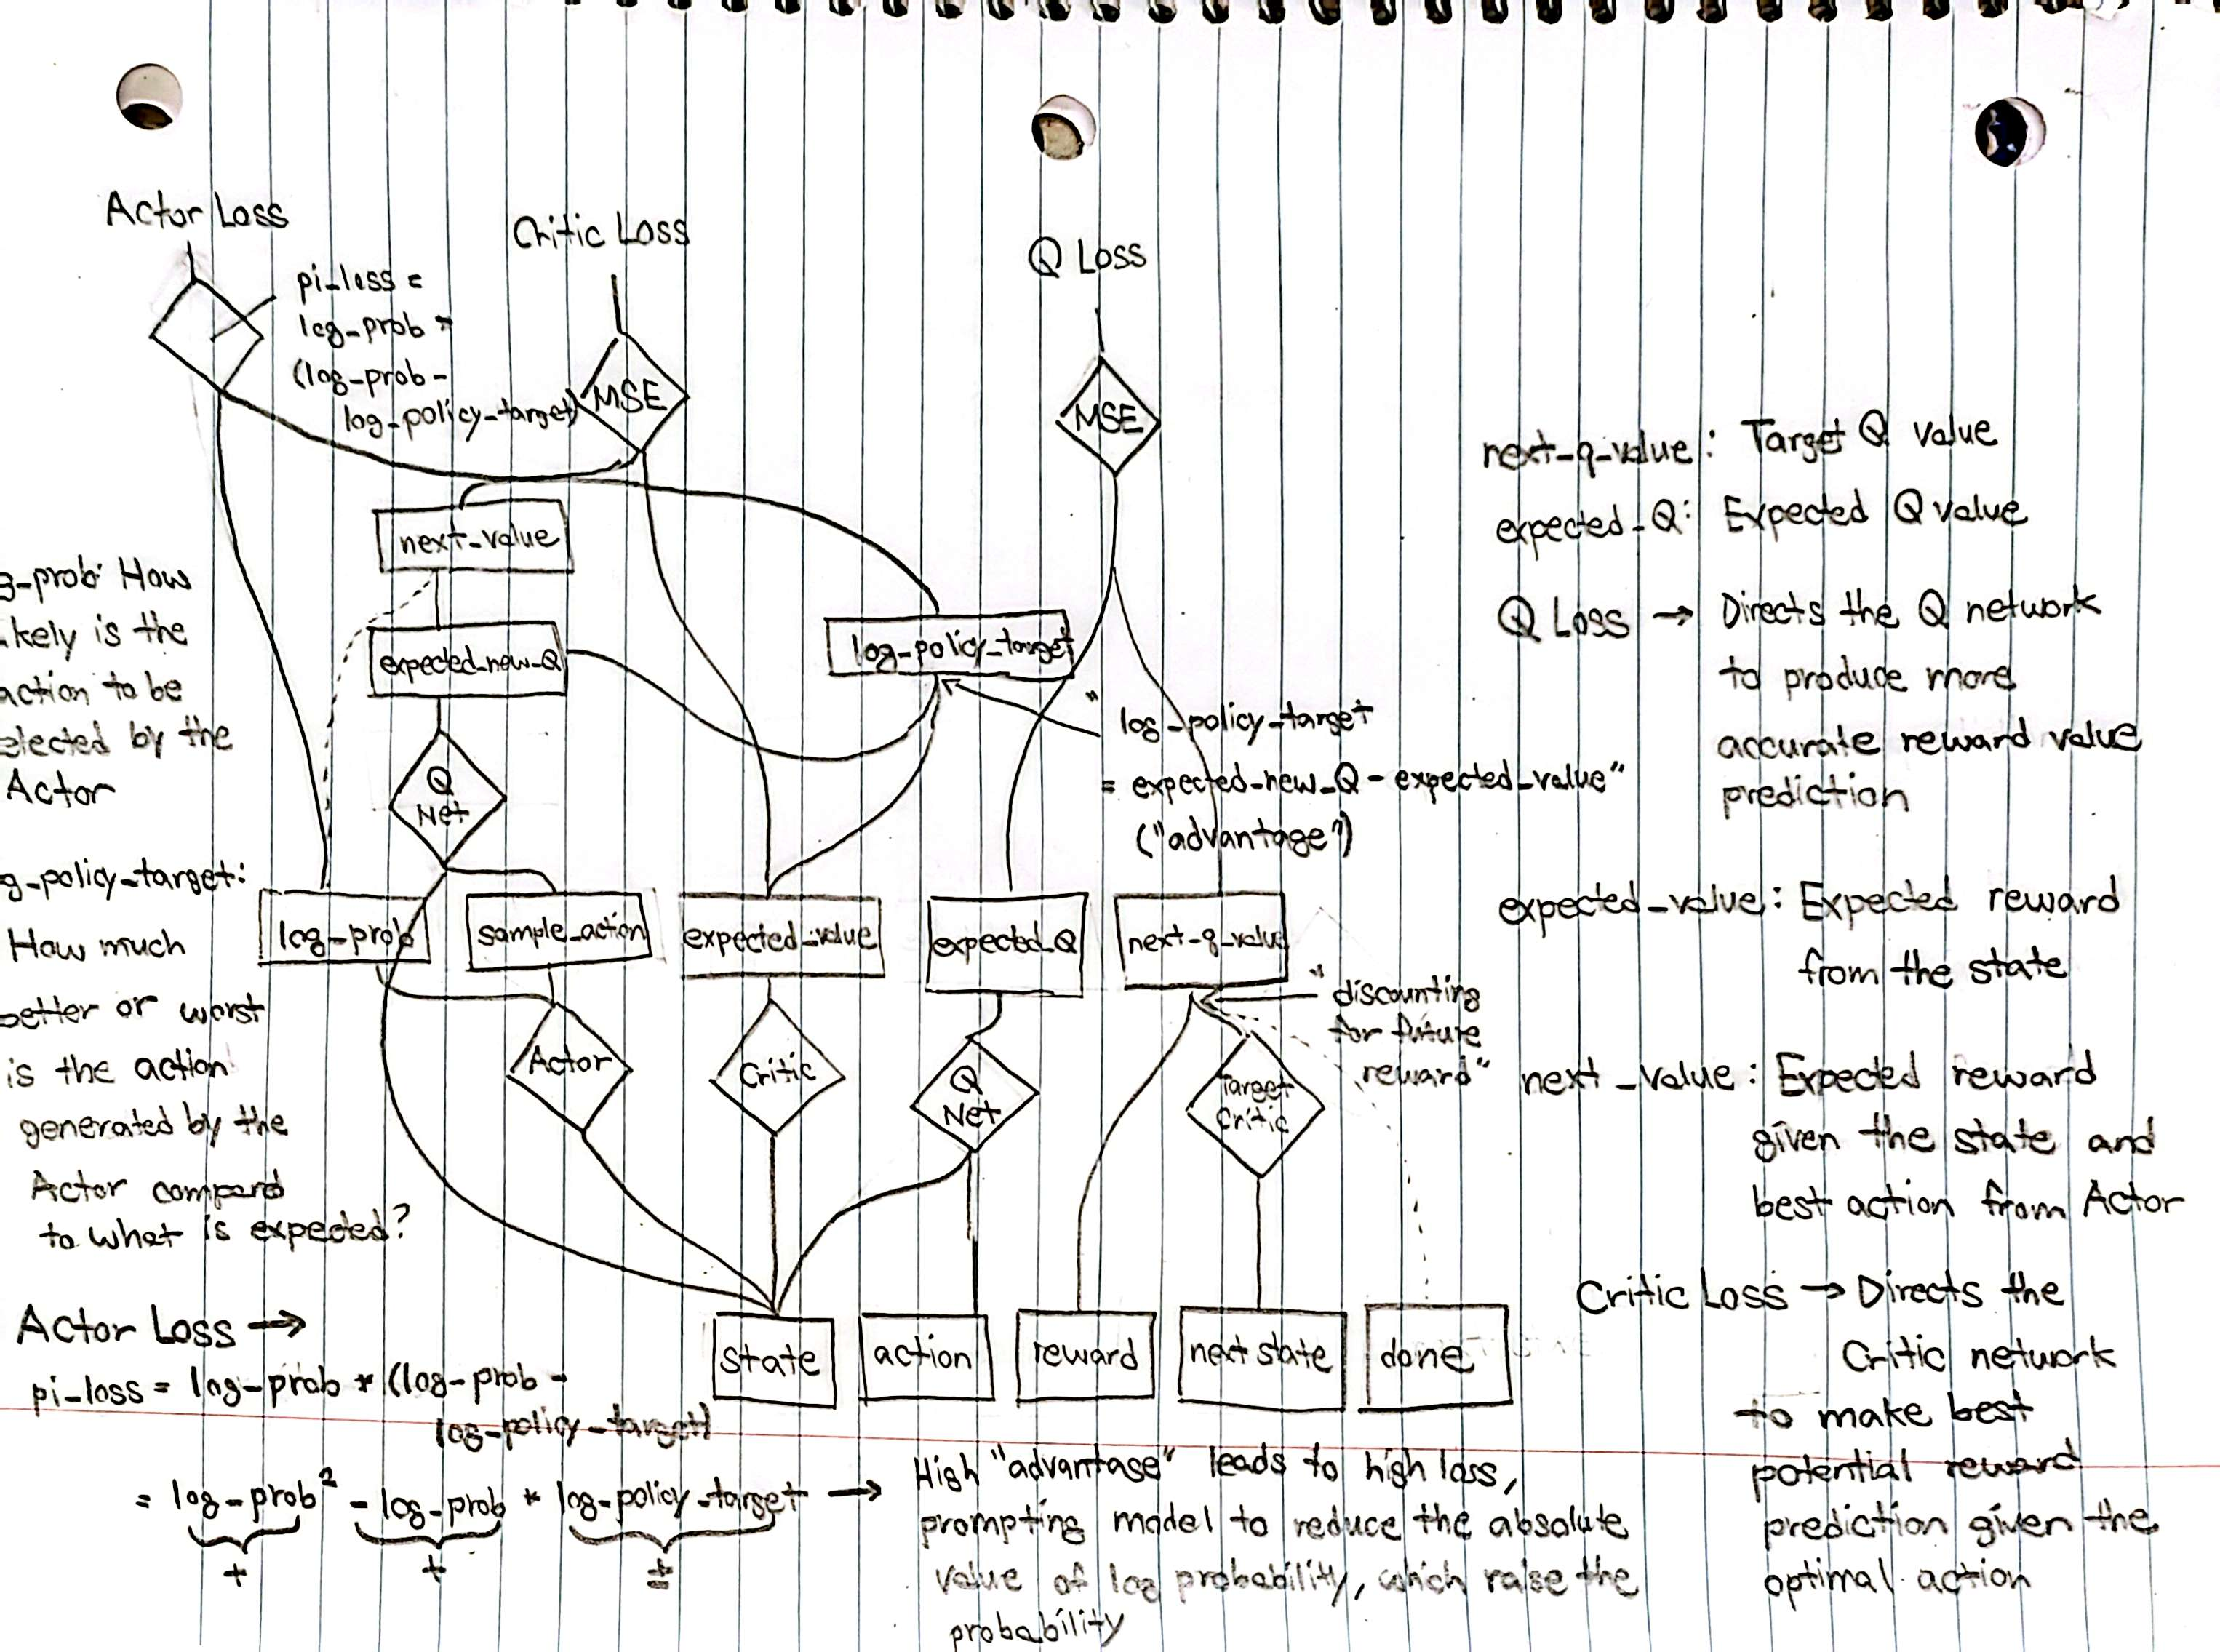

### Model Dependency Graph for update function

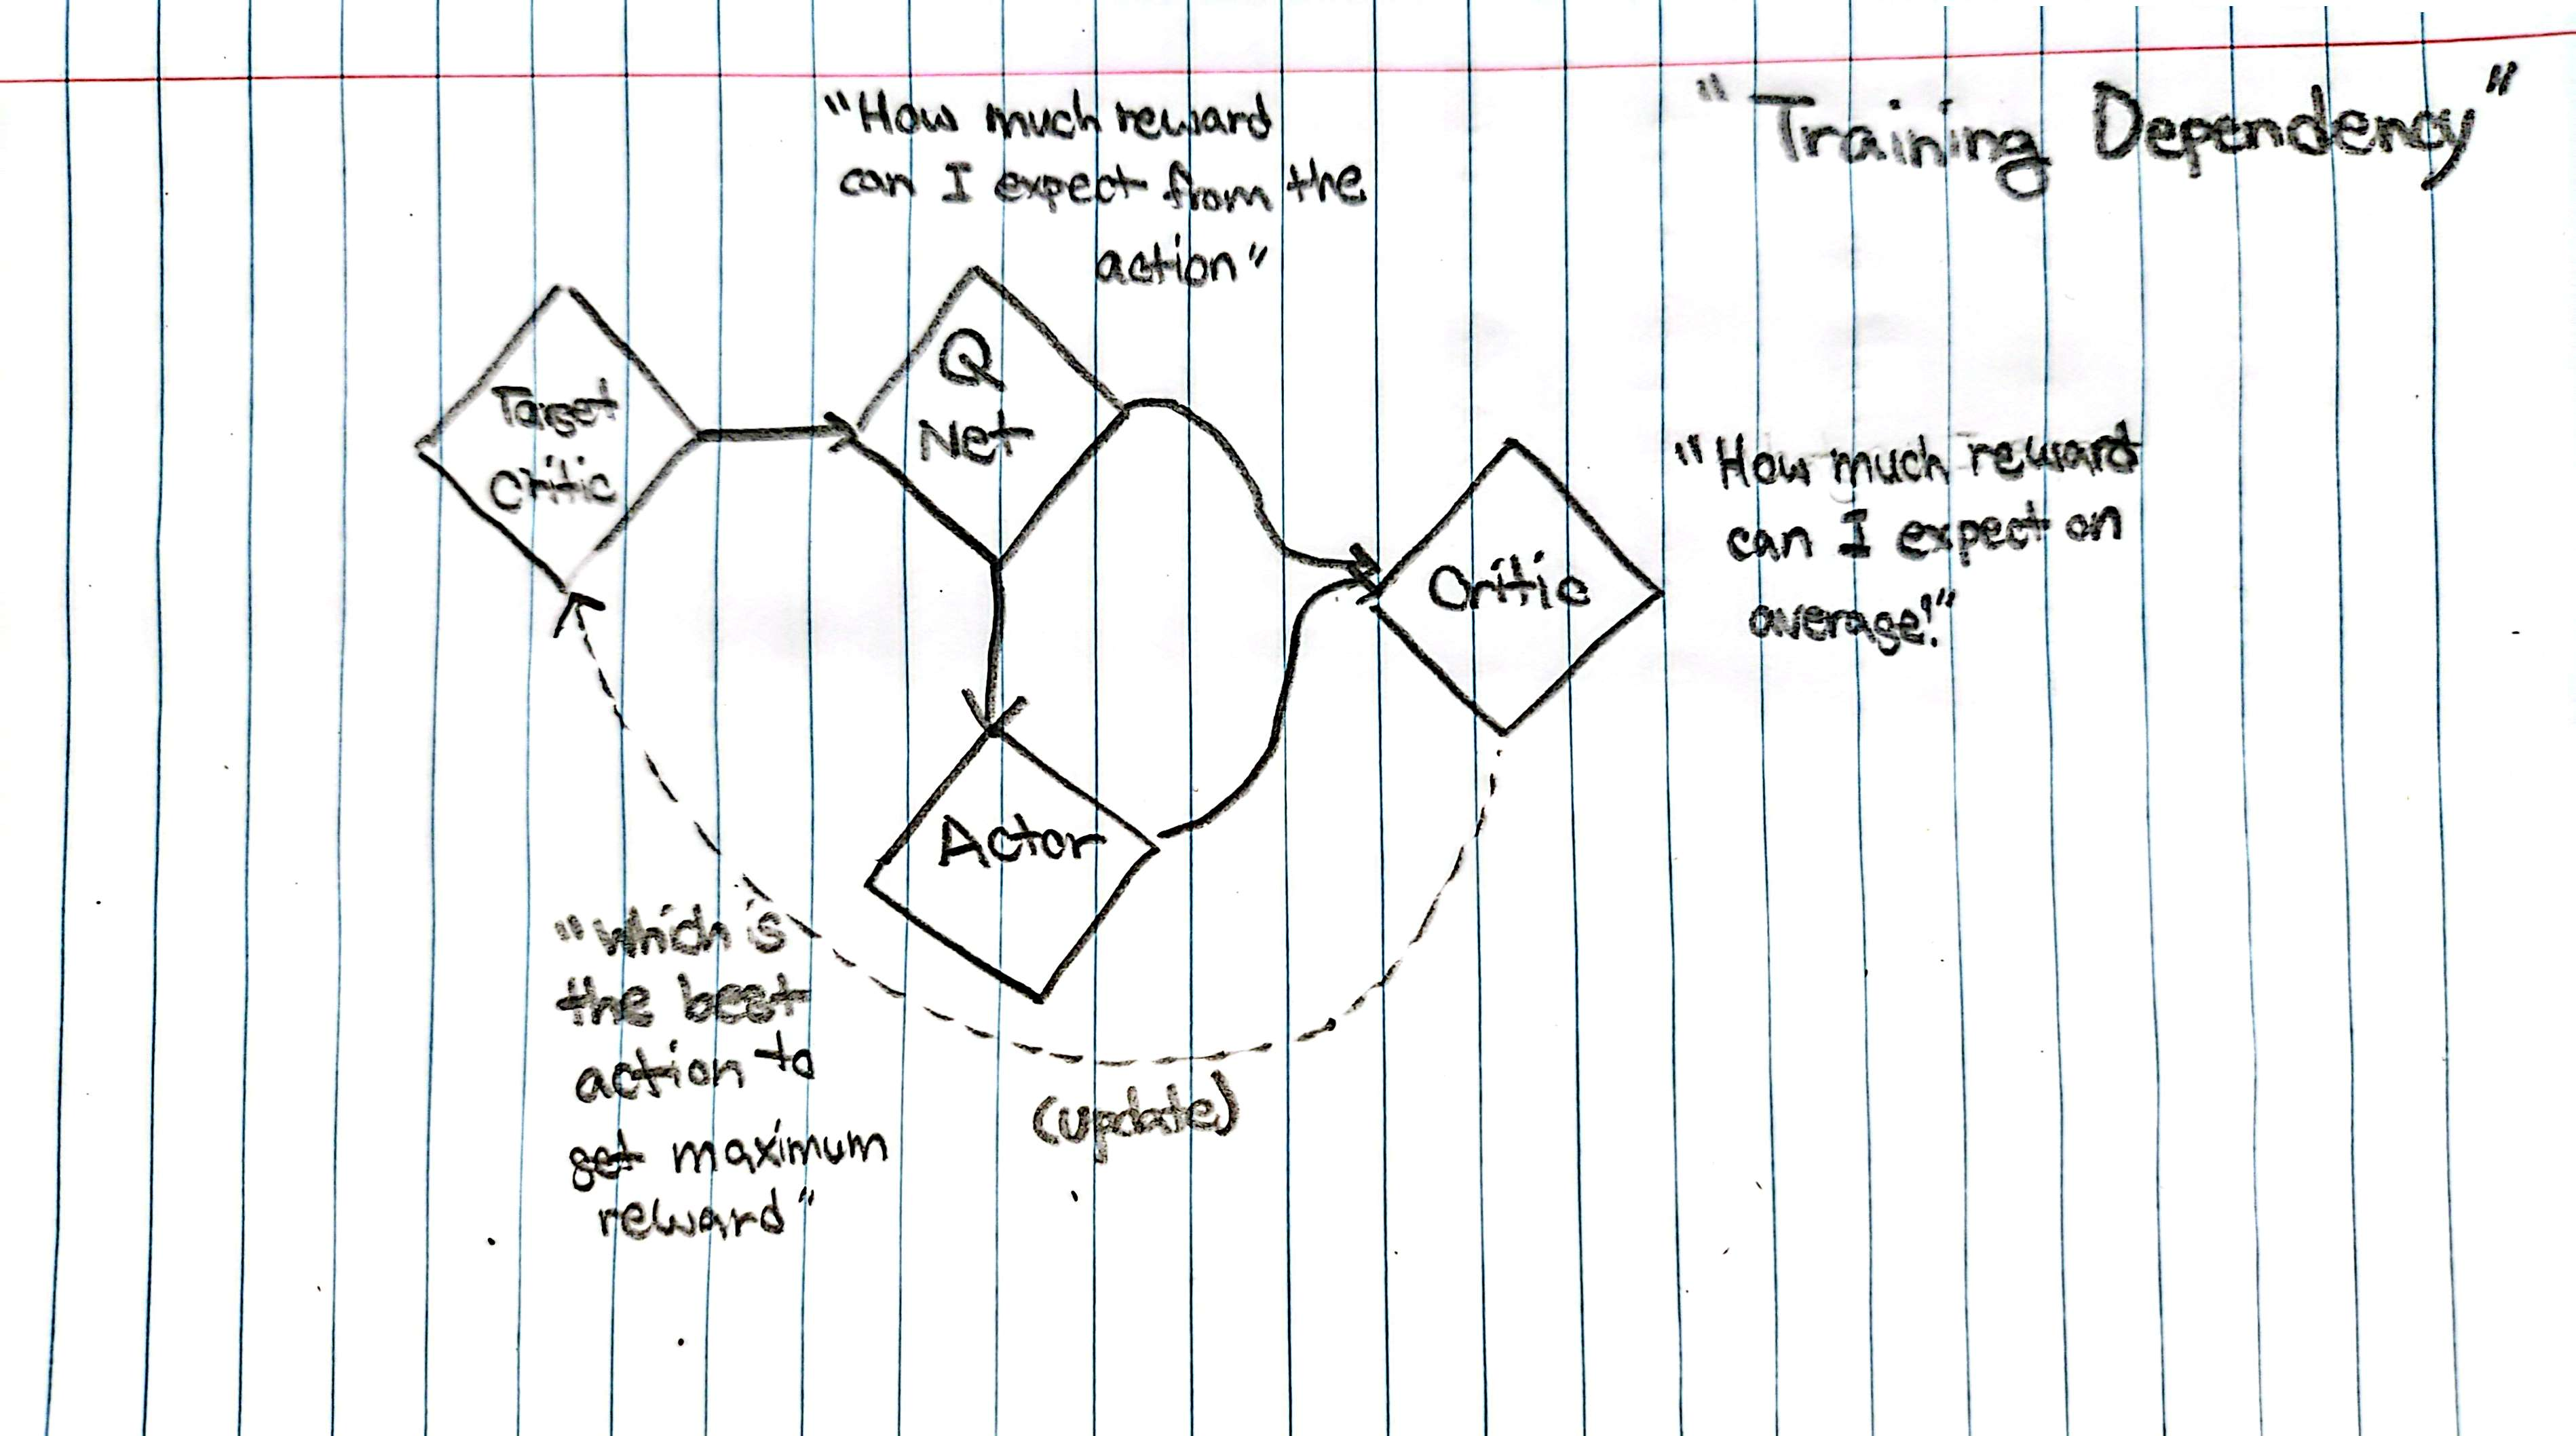

### Formula break down for `log_dist = dist.log_prob(z) - torch.log(1 - action.pow(2) + min_Val)`

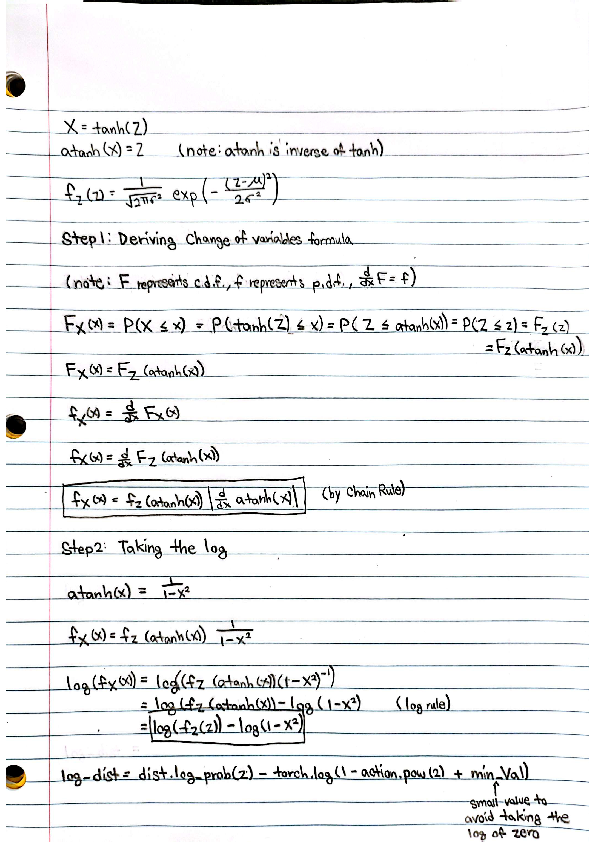

In [ ]:
import pickle
from collections import namedtuple
from itertools import count

import os
import numpy as np

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.autograd import grad
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from tensorboardX import SummaryWriter

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hard-coded parameter values
env_name = "Pendulum-v1"
tau = 0.005
target_update_interval = 1
gradient_steps = 1
learning_rate = 3e-4
gamma = 0.99
capacity = 10000
iteration = 100000
batch_size = 128
seed = 1

# Optional parameters
num_hidden_layers = 2
num_hidden_units_per_layer = 256
sample_frequency = 256
activation = 'Relu'
render = False
log_interval = 2000
load = False

class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low = self.action_space.low
        high = self.action_space.high

        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action):
        low = self.action_space.low
        high = self.action_space.high

        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)

        return action


env = NormalizedActions(gym.make(env_name))

# Set seeds
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
min_Val = torch.tensor(1e-7).float().to(device)  # make sure this is a float
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_', 'd'])

class Actor(nn.Module):
    def __init__(self, state_dim, min_log_std=-20, max_log_std=2):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mu_head = nn.Linear(256, 1)
        self.log_std_head = nn.Linear(256, 1)
        self.max_action = max_action

        self.min_log_std = min_log_std
        self.max_log_std = max_log_std

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mu_head(x)
        log_std_head = F.relu(self.log_std_head(x))
        log_std_head = torch.clamp(log_std_head, self.min_log_std, self.max_log_std)
        return mu, log_std_head


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Q(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Q, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, s, a):
        s = s.reshape(-1, state_dim)
        a = a.reshape(-1, action_dim)
        x = torch.cat((s, a), -1) # combination s and a
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class SAC():
    def __init__(self):
        super(SAC, self).__init__()

        self.policy_net = Actor(state_dim).to(device)
        self.value_net = Critic(state_dim).to(device)
        self.Q_net = Q(state_dim, action_dim).to(device)
        self.Target_value_net = Critic(state_dim).to(device)

        self.replay_buffer = [Transition] * capacity
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=learning_rate)
        self.Q_optimizer = optim.Adam(self.Q_net.parameters(), lr=learning_rate)
        self.num_transition = 0 # pointer of replay buffer
        self.num_training = 1
        self.writer = SummaryWriter('./exp-SAC')

        self.value_criterion = nn.MSELoss()
        self.Q_criterion = nn.MSELoss()

        for target_param, param in zip(self.Target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(param.data)

        os.makedirs('./SAC_model/', exist_ok=True)

    def select_action(self, state):
        state = torch.FloatTensor(state).float().to(device)  # make sure this is float
        mu, log_sigma = self.policy_net(state)
        sigma = torch.exp(log_sigma)
        dist = Normal(mu, sigma)
        z = dist.sample()
        action = torch.tanh(z).detach().cpu().numpy()
        return action.item() # return a scalar, float32

    def store(self, s, a, r, s_, d):
        index = self.num_transition % capacity
        transition = Transition(s, a, r, s_, d)
        self.replay_buffer[index] = transition
        self.num_transition += 1

    def get_action_log_prob(self, state):

        batch_mu, batch_log_sigma = self.policy_net(state)
        batch_sigma = torch.exp(batch_log_sigma)
        dist = Normal(batch_mu, batch_sigma)
        z = dist.sample()
        action = torch.tanh(z)
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + min_Val)
        return action, log_prob, z, batch_mu, batch_log_sigma


    def update(self):
        if self.num_training % 500 == 0:
            print("Training ... {} ".format(self.num_training))
        s = torch.tensor([t.s for t in self.replay_buffer], dtype=torch.float).to(device)
        a = torch.tensor([t.a for t in self.replay_buffer], dtype=torch.float).to(device)
        r = torch.tensor([t.r for t in self.replay_buffer], dtype=torch.float).to(device)
        s_ = torch.tensor([t.s_ for t in self.replay_buffer], dtype=torch.float).to(device)
        d = torch.tensor([t.d for t in self.replay_buffer], dtype=torch.float).to(device)

        for _ in range(gradient_steps):
            #for index in BatchSampler(SubsetRandomSampler(range(capacity)), batch_size, False):
            index = np.random.choice(range(capacity), batch_size, replace=False)
            bn_s = s[index]
            bn_a = a[index].reshape(-1, 1).float()
            bn_r = r[index].reshape(-1, 1).float()
            bn_s_ = s_[index]
            bn_d = d[index].reshape(-1, 1).float()

            target_value = self.Target_value_net(bn_s_)
            next_q_value = bn_r + (1 - bn_d) * gamma * target_value

            excepted_value = self.value_net(bn_s)
            excepted_Q = self.Q_net(bn_s, bn_a)

            sample_action, log_prob, z, batch_mu, batch_log_sigma = self.get_action_log_prob(bn_s)
            excepted_new_Q = self.Q_net(bn_s, sample_action)
            next_value = excepted_new_Q - log_prob

            # !!!Note that the actions are sampled according to the current policy,
            # instead of replay buffer. (From original paper)

            V_loss = self.value_criterion(excepted_value, next_value.detach())  # J_V
            V_loss = V_loss.mean()

            # Single Q_net this is different from original paper!!!
            Q_loss = self.Q_criterion(excepted_Q, next_q_value.detach()) # J_Q
            Q_loss = Q_loss.mean()

            log_policy_target = excepted_new_Q - excepted_value

            pi_loss = log_prob * (log_prob- log_policy_target).detach()
            pi_loss = pi_loss.mean()

            self.writer.add_scalar('Loss/V_loss', V_loss, global_step=self.num_training)
            self.writer.add_scalar('Loss/Q_loss', Q_loss, global_step=self.num_training)
            self.writer.add_scalar('Loss/pi_loss', pi_loss, global_step=self.num_training)
            # mini batch gradient descent
            self.value_optimizer.zero_grad()
            V_loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.value_net.parameters(), 0.5)
            self.value_optimizer.step()

            self.Q_optimizer.zero_grad()
            Q_loss.backward(retain_graph = True)
            nn.utils.clip_grad_norm_(self.Q_net.parameters(), 0.5)
            self.Q_optimizer.step()

            self.policy_optimizer.zero_grad()
            pi_loss.backward(retain_graph = True)
            nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
            self.policy_optimizer.step()

            # soft update
            for target_param, param in zip(self.Target_value_net.parameters(), self.value_net.parameters()):
                target_param.data.copy_(target_param * (1 - tau) + param * tau)

            self.num_training += 1

    def save(self):
        torch.save(self.policy_net.state_dict(), './SAC_model/policy_net.pth')
        torch.save(self.value_net.state_dict(), './SAC_model/value_net.pth')
        torch.save(self.Q_net.state_dict(), './SAC_model/Q_net.pth')
        print("====================================")
        print("Model has been saved...")
        print("====================================")

    def load(self):
        torch.load(self.policy_net.state_dict(), './SAC_model/policy_net.pth')
        torch.load(self.value_net.state_dict(), './SAC_model/value_net.pth')
        torch.load(self.Q_net.state_dict(), './SAC_model/Q_net.pth')
        print()

def main():

    agent = SAC()
    if load: agent.load()
    if render: env.render()
    print("====================================")
    print("Collection Experience...")
    print("====================================")

    ep_r = 0
    for i in range(iteration):
        state = env.reset()
        for t in range(200):
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(np.float32(action))
            ep_r += reward
            if render: env.render()
            agent.store(state, action, reward, next_state, done)

            if agent.num_transition >= capacity:
                agent.update()

            state = next_state
            if done or t == 199:
                if i % 10 == 0:
                    print("Ep_i {}, the ep_r is {}, the t is {}".format(i, ep_r, t))
                break
        if i % log_interval == 0:
            agent.save()
        agent.writer.add_scalar('ep_r', ep_r, global_step=i)
        ep_r = 0


if __name__ == '__main__':
    main()